# Solar Data Analysis: PR and GHI Relationship

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Set visualization style for consistency
sns.set_style("whitegrid")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Create output directory
os.makedirs("output", exist_ok=True)

In [2]:
def preprocess_solar_data(ghi_data_dir="data/GHI", pr_data_dir="data/PR"):
    """
    Consolidated function to load, merge, and clean GHI and PR data
    """
    # --- Load GHI Data ---
    ghi_files = glob.glob(f"{ghi_data_dir}/**/*.csv", recursive=True)
    ghi_dfs = []
    for file in ghi_files:
        df = pd.read_csv(file)
        df = df[pd.to_numeric(df['GHI'], errors='coerce').notna()]
        ghi_dfs.append(df)
    ghi_data = pd.concat(ghi_dfs, ignore_index=True)
    ghi_data['Date'] = pd.to_datetime(ghi_data['Date'])
    ghi_data = ghi_data.drop_duplicates(subset=['Date']).sort_values('Date').reset_index(drop=True)
    print(f"[INFO] Loaded GHI data: {ghi_data.shape[0]} records")

    # --- Load PR Data ---
    pr_files = glob.glob(f"{pr_data_dir}/**/*.csv", recursive=True)
    pr_dfs = []
    for file in pr_files:
        df = pd.read_csv(file)
        df = df[pd.to_numeric(df['PR'], errors='coerce').notna()]
        pr_dfs.append(df)
    pr_data = pd.concat(pr_dfs, ignore_index=True)
    pr_data['Date'] = pd.to_datetime(pr_data['Date'])
    pr_data = pr_data.drop_duplicates(subset=['Date']).sort_values('Date').reset_index(drop=True)
    print(f"[INFO] Loaded PR data: {pr_data.shape[0]} records")

    # --- Merge and Clean ---
    merged_df = pd.merge(ghi_data, pr_data, on='Date', how='inner')
    merged_df['GHI'] = pd.to_numeric(merged_df['GHI'], errors='coerce')
    merged_df['PR'] = pd.to_numeric(merged_df['PR'], errors='coerce')
    print(f"[INFO] Merged GHI and PR data: {merged_df.shape[0]} records")

    # --- Save merged data ---
    output_file = "output/merged_solar_data.csv"
    merged_df.to_csv(output_file, index=False)
    print(f"[INFO] Saved merged data to {output_file}")

    return merged_df

# Preprocess and load data
df = preprocess_solar_data("data/GHI", "data/PR")
print(df.head())

[INFO] Loaded GHI data: 982 records
[INFO] Loaded PR data: 982 records
[INFO] Merged GHI and PR data: 982 records
[INFO] Saved merged data to output/merged_solar_data.csv
        Date       GHI         PR
0 2019-07-01  3.256608  69.575676
1 2019-07-02  3.976767  79.314411
2 2019-07-03  2.811867  61.020006
3 2019-07-04  3.658408  83.262576
4 2019-07-05  5.590683  82.124440


## PR Visualization Function

In [3]:
def plot_pr_graph(
    df, 
    output_path="output/pr_graph.png", 
    start_date=None, 
    end_date=None, 
    title="Daily PR with GHI Coloring and Budget Line"
):
    """
    Create a standardized PR graph with GHI color-coding and performance metrics
    """
    # Filter by date
    filtered_df = df.copy()
    if start_date:
        filtered_df = filtered_df[filtered_df["Date"] >= pd.to_datetime(start_date)]
    if end_date:
        filtered_df = filtered_df[filtered_df["Date"] <= pd.to_datetime(end_date)]
    filtered_df = filtered_df.sort_values("Date").reset_index(drop=True)

    # --- Calculate moving average and budget PR ---
    filtered_df["PR_MA_30"] = filtered_df["PR"].rolling(window=30).mean()
    filtered_df["Budget_PR"] = 73.9 * (0.992 ** ((filtered_df["Date"].dt.year - 2019) + 
                                      ((filtered_df["Date"].dt.month - 7) / 12)).clip(lower=0))

    # --- Metrics calculations ---
    points_above_budget = (filtered_df["PR"] > filtered_df["Budget_PR"]).mean() * 100
    current_date = filtered_df["Date"].max()
    pr_averages = {"Lifetime": filtered_df["PR"].mean()}
    for days in [365, 90, 60, 30, 7]:
        cutoff = current_date - pd.Timedelta(days=days)
        period_data = filtered_df[filtered_df["Date"] >= cutoff]
        pr_averages[f"{days}d"] = period_data["PR"].mean() if not period_data.empty else None

    # --- GHI color mapping ---
    def ghi_color(val):
        if val < 2: return "navy"
        elif val < 4: return "lightblue"
        elif val < 6: return "orange"
        else: return "brown"
    colors = filtered_df["GHI"].apply(ghi_color)

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(18, 10))
    ax.scatter(filtered_df["Date"], filtered_df["PR"], c=colors, alpha=0.7)
    ax.plot(filtered_df["Date"], filtered_df["PR_MA_30"], color="red", linewidth=2, label="30-day PR Avg")
    ax.plot(filtered_df["Date"], filtered_df["Budget_PR"], color="darkgreen", linestyle="--", linewidth=2, label="Budget PR")
    ax.legend(loc='upper right', fontsize=12)
    ax.set(title=title, xlabel="Date", ylabel="Performance Ratio (%)")
    ax.set_ylim(filtered_df["PR"].min() * 0.95, filtered_df["PR"].max() * 1.02)
    ax.grid(True, alpha=0.3)

    # --- Metrics text box ---
    metrics_text = f"Points above Budget PR: {points_above_budget:.1f}%\n\nAverage PR:\n"
    for period, value in pr_averages.items():
        if value is not None:
            metrics_text += f"{period}: {value:.2f}%\n"
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax.text(0.02, 0.02, metrics_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()

    return {
        "points_above_budget": points_above_budget,
        "pr_averages": pr_averages
    }

## PR-GHI Relationship Analysis

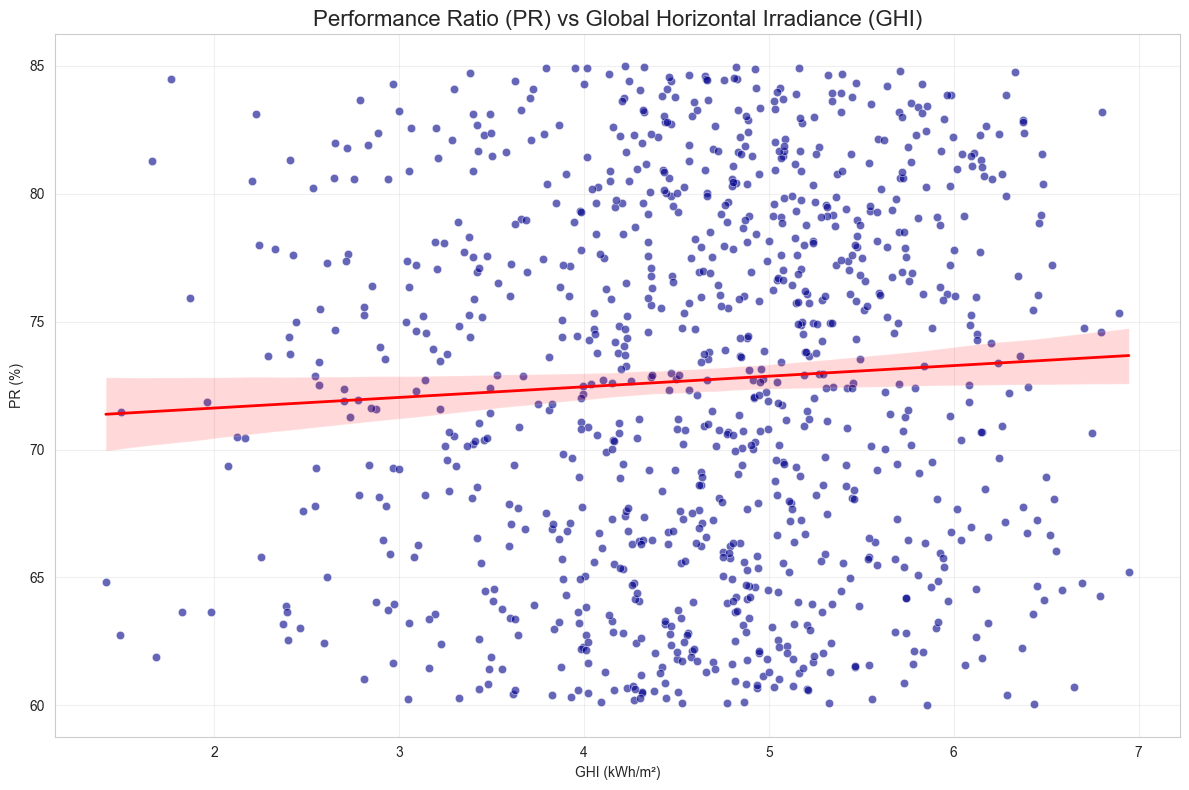

Pearson correlation: r = 0.0582, p-value: 0.0681
The correlation is not statistically significant (p > 0.05)

PR statistics by GHI bin:
  GHI_bin         PR                                      
                mean       std count        min        max
0     0-2  70.176208  8.182009    10  61.884705  84.471002
1     2-4  72.342182  6.984525   229  60.241675  84.924373
2     4-6  72.848169  7.408973   662  60.023886  84.980120
3     6-8  72.993258  7.133649    81  60.065305  84.769984


C:\Users\dhruv\AppData\Local\Temp\ipykernel_25720\2884083411.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby('GHI_bin').agg({'PR': ['mean', 'std', 'count', 'min', 'max']}).reset_index()
C:\Users\dhruv\AppData\Local\Temp\ipykernel_25720\2884083411.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GHI_bin', y='PR', data=df, palette='viridis')


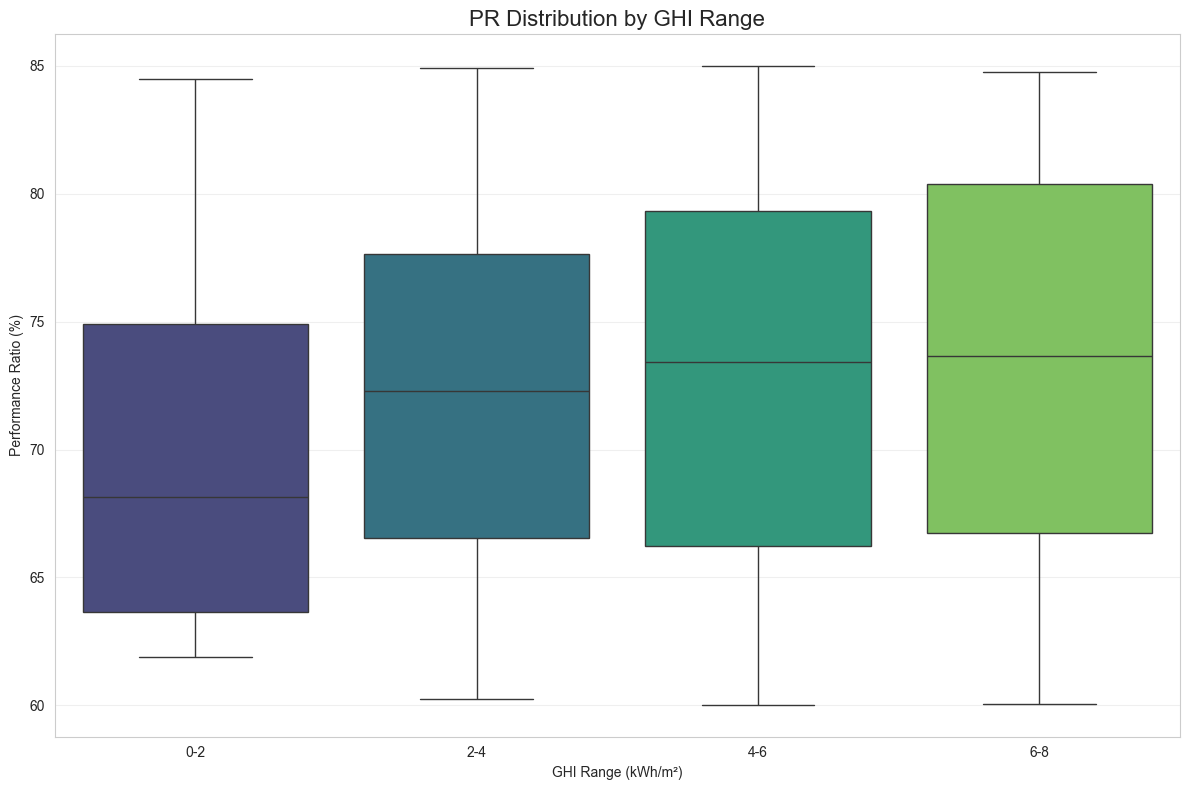

In [5]:
def analyze_pr_ghi_relationship(df):
    """
    Analyze the relationship between PR and GHI
    """
    # --- Scatter plot with regression line ---
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='GHI', y='PR', data=df, alpha=0.6, color='darkblue')
    sns.regplot(x='GHI', y='PR', data=df, scatter=False, color='red', line_kws={'linewidth': 2})
    plt.title('Performance Ratio (PR) vs Global Horizontal Irradiance (GHI)', fontsize=16)
    plt.xlabel('GHI (kWh/m²)')
    plt.ylabel('PR (%)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("output/pr_ghi_scatter.png", dpi=300)
    plt.show()

    # --- Correlation ---
    correlation, p_value = stats.pearsonr(df['GHI'], df['PR'])
    print(f"Pearson correlation: r = {correlation:.4f}, p-value: {p_value:.4f}")
    print("The correlation is statistically significant (p < 0.05)" if p_value < 0.05 else "The correlation is not statistically significant (p > 0.05)")

    # --- GHI binning and statistics ---
    df['GHI_bin'] = pd.cut(df['GHI'], bins=[0, 2, 4, 6, 8], labels=['0-2', '2-4', '4-6', '6-8'])
    bin_stats = df.groupby('GHI_bin').agg({'PR': ['mean', 'std', 'count', 'min', 'max']}).reset_index()
    print("\nPR statistics by GHI bin:")
    print(bin_stats)

    # --- Boxplot by GHI range ---
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='GHI_bin', y='PR', data=df, palette='viridis')
    plt.title('PR Distribution by GHI Range', fontsize=16)
    plt.xlabel('GHI Range (kWh/m²)')
    plt.ylabel('Performance Ratio (%)')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig("output/pr_by_ghi_boxplot.png", dpi=300)
    plt.show()

# Analyze PR-GHI relationship
analyze_pr_ghi_relationship(df)

# Seasonal Patterns

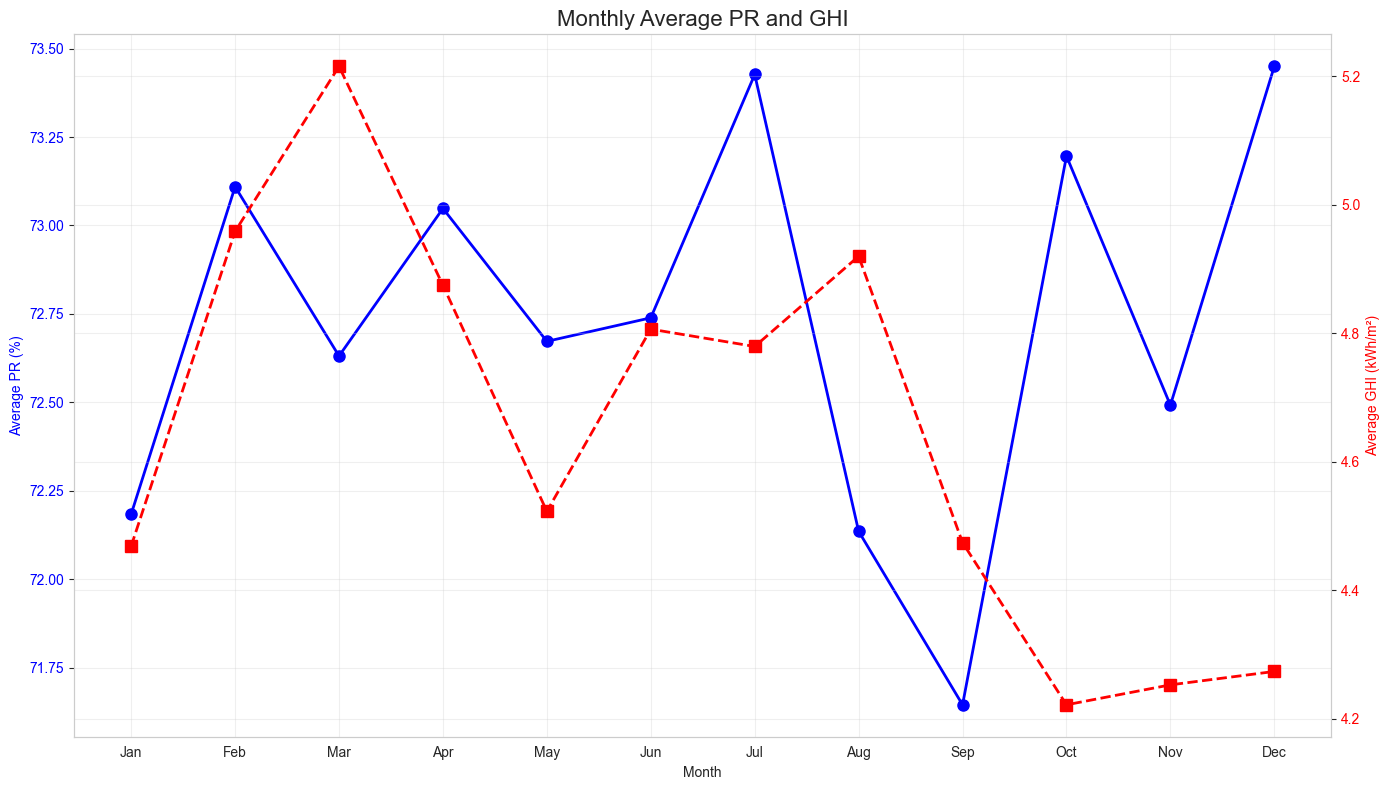

C:\Users\dhruv\AppData\Local\Temp\ipykernel_25720\373915646.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_stats = df.groupby('Season').agg({


Seasonal Statistics:
   Season         PR                       GHI          
                mean       std count      mean       std
0  Winter  72.627488  7.179545   264  4.869637  0.777423
1  Spring  72.799695  7.166582   166  4.719367  1.165975
2  Summer  72.410531  7.515669   276  4.727181  1.126631
3    Fall  73.051997  7.278918   276  4.249539  0.929519


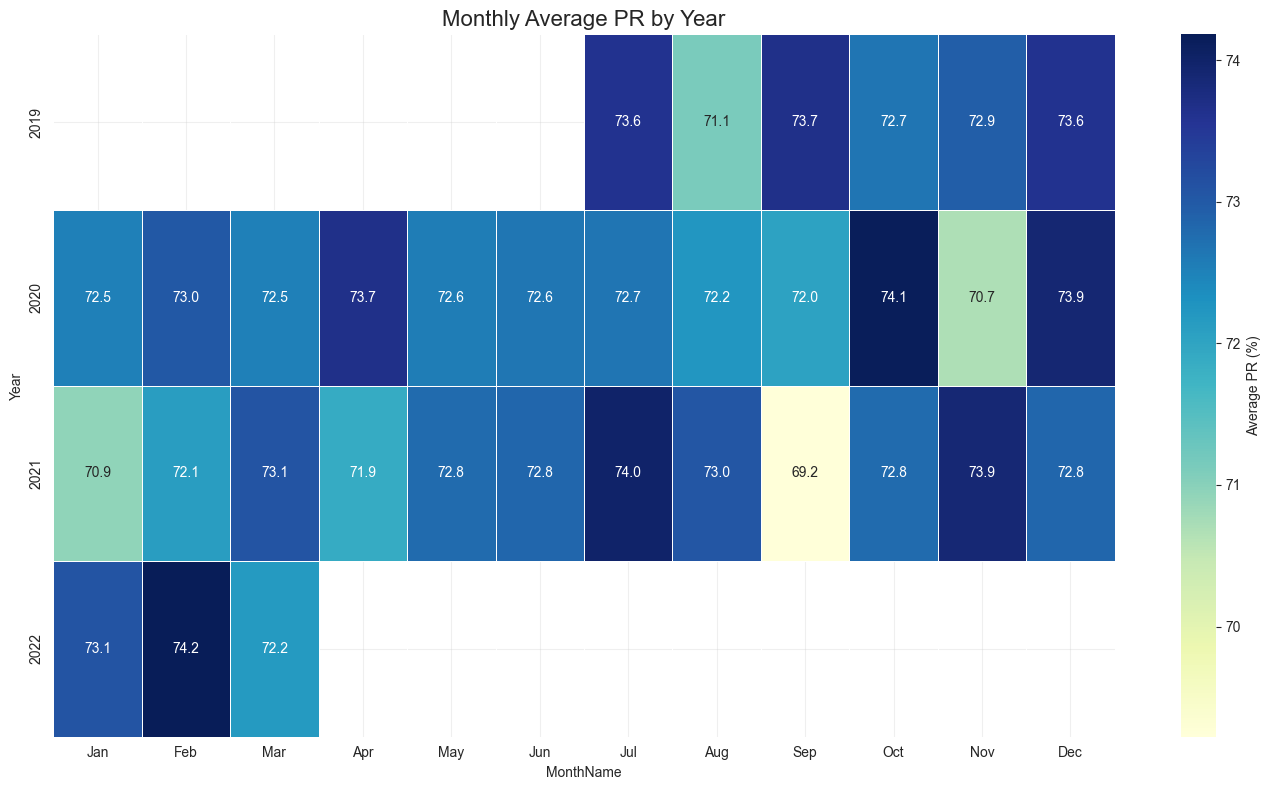

In [6]:
def analyze_seasonal_patterns(df):
    """
    Analyze seasonal and monthly patterns in PR and GHI data.
    """
    # --- Add time features ---
    df['Month'] = df['Date'].dt.month
    df['MonthName'] = df['Date'].dt.strftime('%b')
    df['Season'] = pd.cut(
        df['Month'], 
        bins=[0, 3, 6, 9, 12], 
        labels=['Winter', 'Spring', 'Summer', 'Fall'],
        include_lowest=False,
        right=True
    )

    # --- Monthly averages ---
    monthly_pr = df.groupby('Month')['PR'].mean().reset_index()
    monthly_ghi = df.groupby('Month')['GHI'].mean().reset_index()

    # --- Dual-axis plot for monthly PR and GHI ---
    fig, ax1 = plt.subplots(figsize=(14, 8))
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Average PR (%)', color='blue')
    ax1.plot(monthly_pr['Month'], monthly_pr['PR'], marker='o', color='blue', linewidth=2, markersize=8)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Average GHI (kWh/m²)', color='red')
    ax2.plot(monthly_ghi['Month'], monthly_ghi['GHI'], marker='s', linestyle='--', color='red', linewidth=2, markersize=8)
    ax2.tick_params(axis='y', labelcolor='red')
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.xticks(range(1, 13), month_names)
    plt.title('Monthly Average PR and GHI', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("output/monthly_pr_ghi.png", dpi=300)
    plt.show()

    # --- Seasonal statistics ---
    seasonal_stats = df.groupby('Season').agg({
        'PR': ['mean', 'std', 'count'],
        'GHI': ['mean', 'std']
    }).reset_index()
    print("Seasonal Statistics:")
    print(seasonal_stats)

    # --- PR heatmap by year and month ---
    df['Year'] = df['Date'].dt.year
    monthly_avg = df.pivot_table(index='Year', columns='MonthName', values='PR', aggfunc='mean')
    monthly_avg = monthly_avg.reindex(columns=month_names)
    plt.figure(figsize=(14, 8))
    sns.heatmap(monthly_avg, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Average PR (%)'})
    plt.title("Monthly Average PR by Year", fontsize=16)
    plt.tight_layout()
    plt.savefig("output/pr_monthly_heatmap.png", dpi=300)
    plt.show()

# Analyze seasonal patterns
analyze_seasonal_patterns(df)

## Extreme GHI Analysis

Low GHI days (≤ 2.76 kWh/m²): 50 days, Avg PR: 72.47%, Std: 6.65
High GHI days (≥ 6.19 kWh/m²): 50 days, Avg PR: 72.27%, Std: 7.36


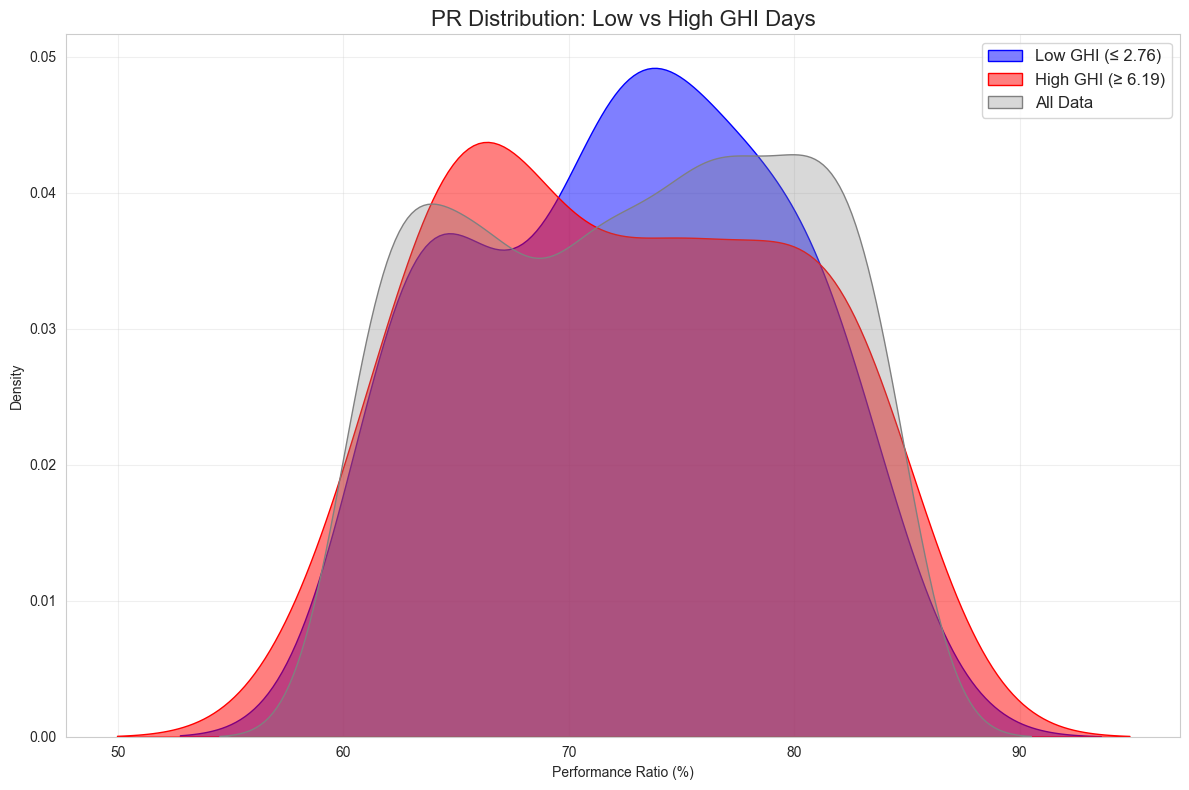


Linear Regression Results:
PR = 0.4148 × GHI + 70.7947
Mean Squared Error: 52.9713
R²: 0.0034


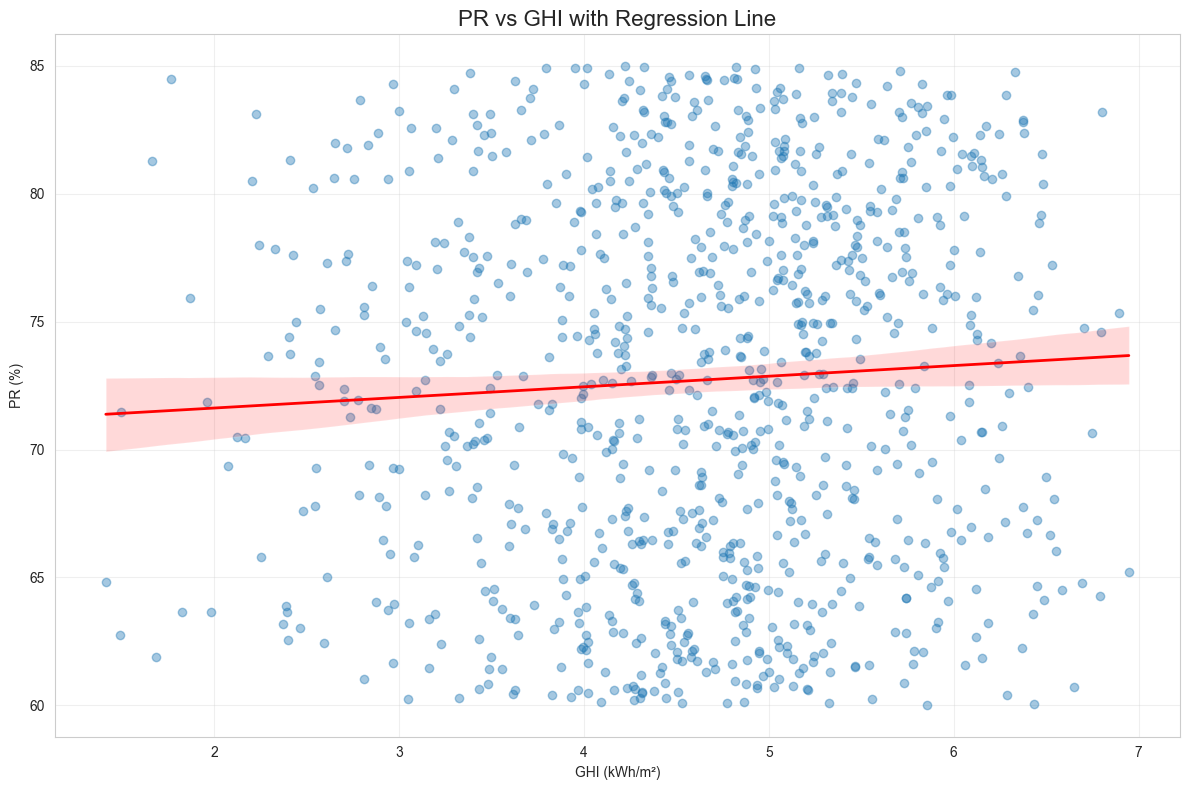

In [7]:
def analyze_extreme_ghi_days(df):
    """
    Analyze PR performance on days with extreme (low/high) GHI values.
    """
    # --- Define thresholds ---
    low_ghi_threshold = df['GHI'].quantile(0.05)
    high_ghi_threshold = df['GHI'].quantile(0.95)
    low_ghi_days = df[df['GHI'] <= low_ghi_threshold]
    high_ghi_days = df[df['GHI'] >= high_ghi_threshold]

    # --- Report statistics ---
    print(f"Low GHI days (≤ {low_ghi_threshold:.2f} kWh/m²): {len(low_ghi_days)} days, Avg PR: {low_ghi_days['PR'].mean():.2f}%, Std: {low_ghi_days['PR'].std():.2f}")
    print(f"High GHI days (≥ {high_ghi_threshold:.2f} kWh/m²): {len(high_ghi_days)} days, Avg PR: {high_ghi_days['PR'].mean():.2f}%, Std: {high_ghi_days['PR'].std():.2f}")

    # --- KDE plots ---
    plt.figure(figsize=(12, 8))
    sns.kdeplot(low_ghi_days['PR'], label=f'Low GHI (≤ {low_ghi_threshold:.2f})', fill=True, alpha=0.5, color='blue')
    sns.kdeplot(high_ghi_days['PR'], label=f'High GHI (≥ {high_ghi_threshold:.2f})', fill=True, alpha=0.5, color='red')
    sns.kdeplot(df['PR'], label='All Data', fill=True, alpha=0.3, color='gray')
    plt.title('PR Distribution: Low vs High GHI Days', fontsize=16)
    plt.xlabel('Performance Ratio (%)')
    plt.ylabel('Density')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("output/pr_distribution_by_ghi_extremes.png", dpi=300)
    plt.show()

    # --- Regression analysis ---
    X = df['GHI'].values.reshape(-1, 1)
    y = df['PR'].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print("\nLinear Regression Results:")
    print(f"PR = {model.coef_[0]:.4f} × GHI + {model.intercept_:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R²: {r2:.4f}")

    # --- Regression plot ---
    plt.figure(figsize=(12, 8))
    sns.regplot(x='GHI', y='PR', data=df, scatter_kws={'alpha': 0.4}, line_kws={'color': 'red', 'linewidth': 2})
    plt.title('PR vs GHI with Regression Line', fontsize=16)
    plt.xlabel('GHI (kWh/m²)')
    plt.ylabel('PR (%)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("output/pr_ghi_regression.png", dpi=300)
    plt.show()

# Analyze extreme GHI days
analyze_extreme_ghi_days(df)

## Performance Summary and Time Series Analysis

=== Performance Summary Statistics ===
Data period: 2019-07-01 to 2022-03-24
Total days: 982
Average PR: 72.71% ± 7.29%
Average GHI: 4.63 ± 1.02 kWh/m²
PR-GHI correlation: 0.0582


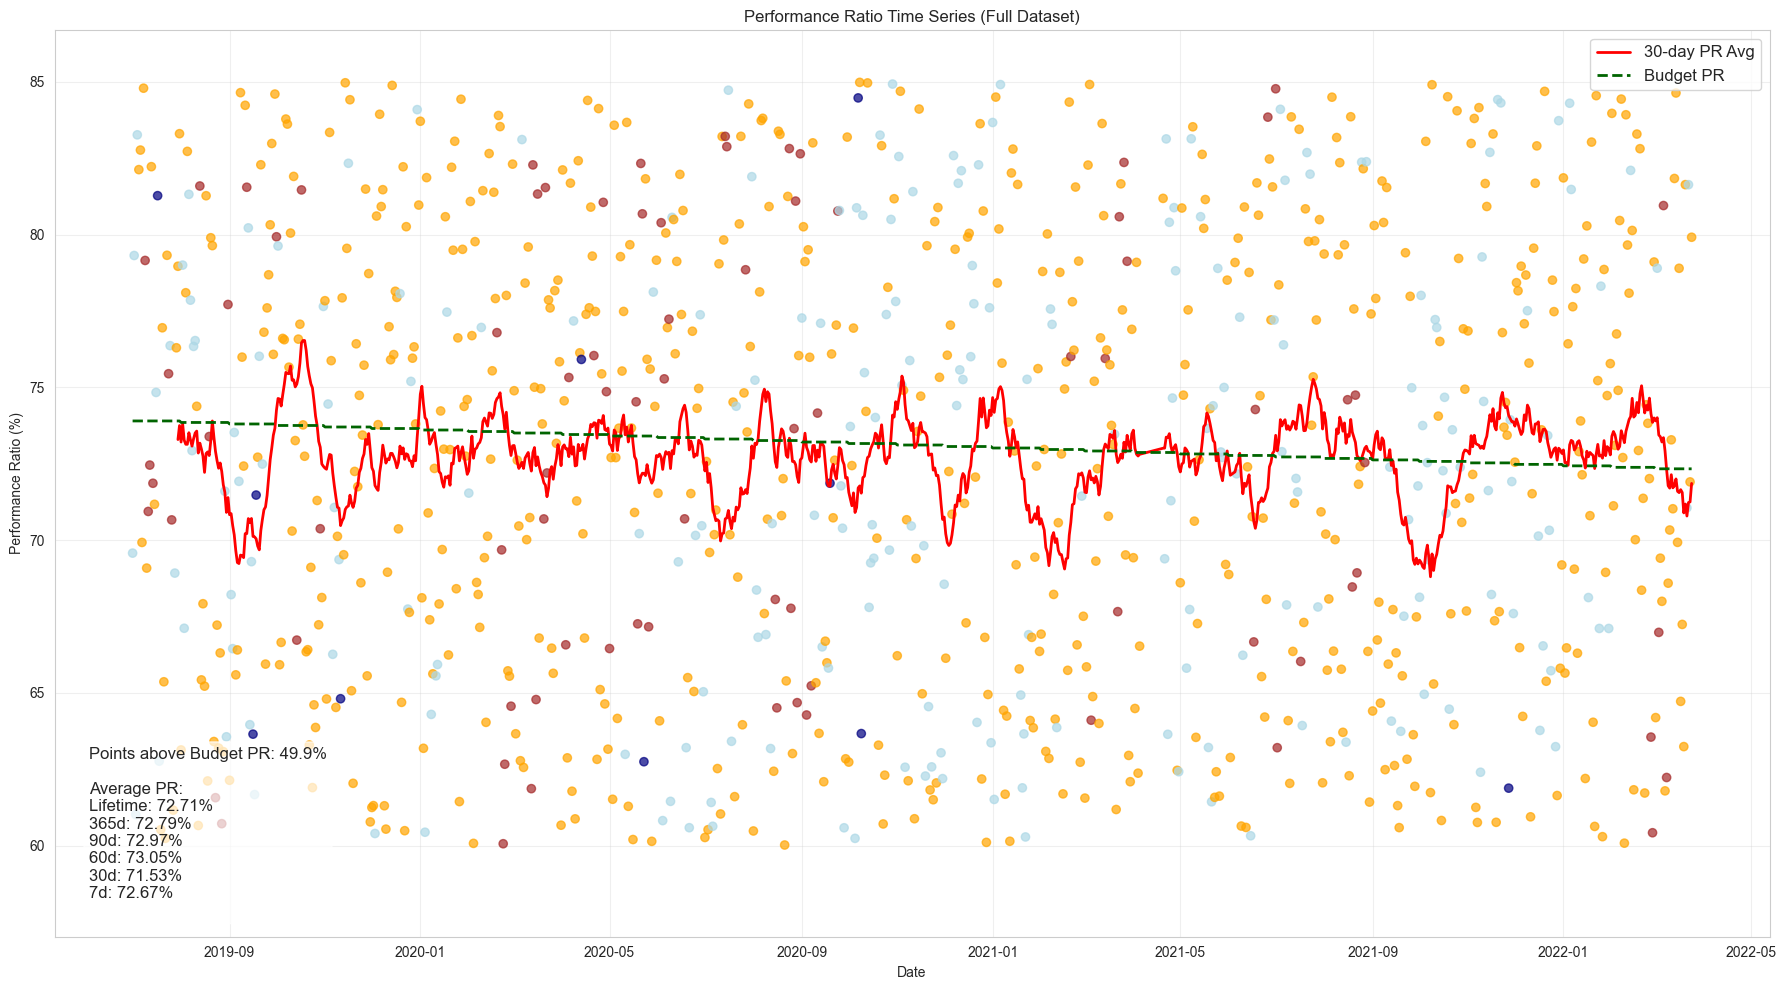

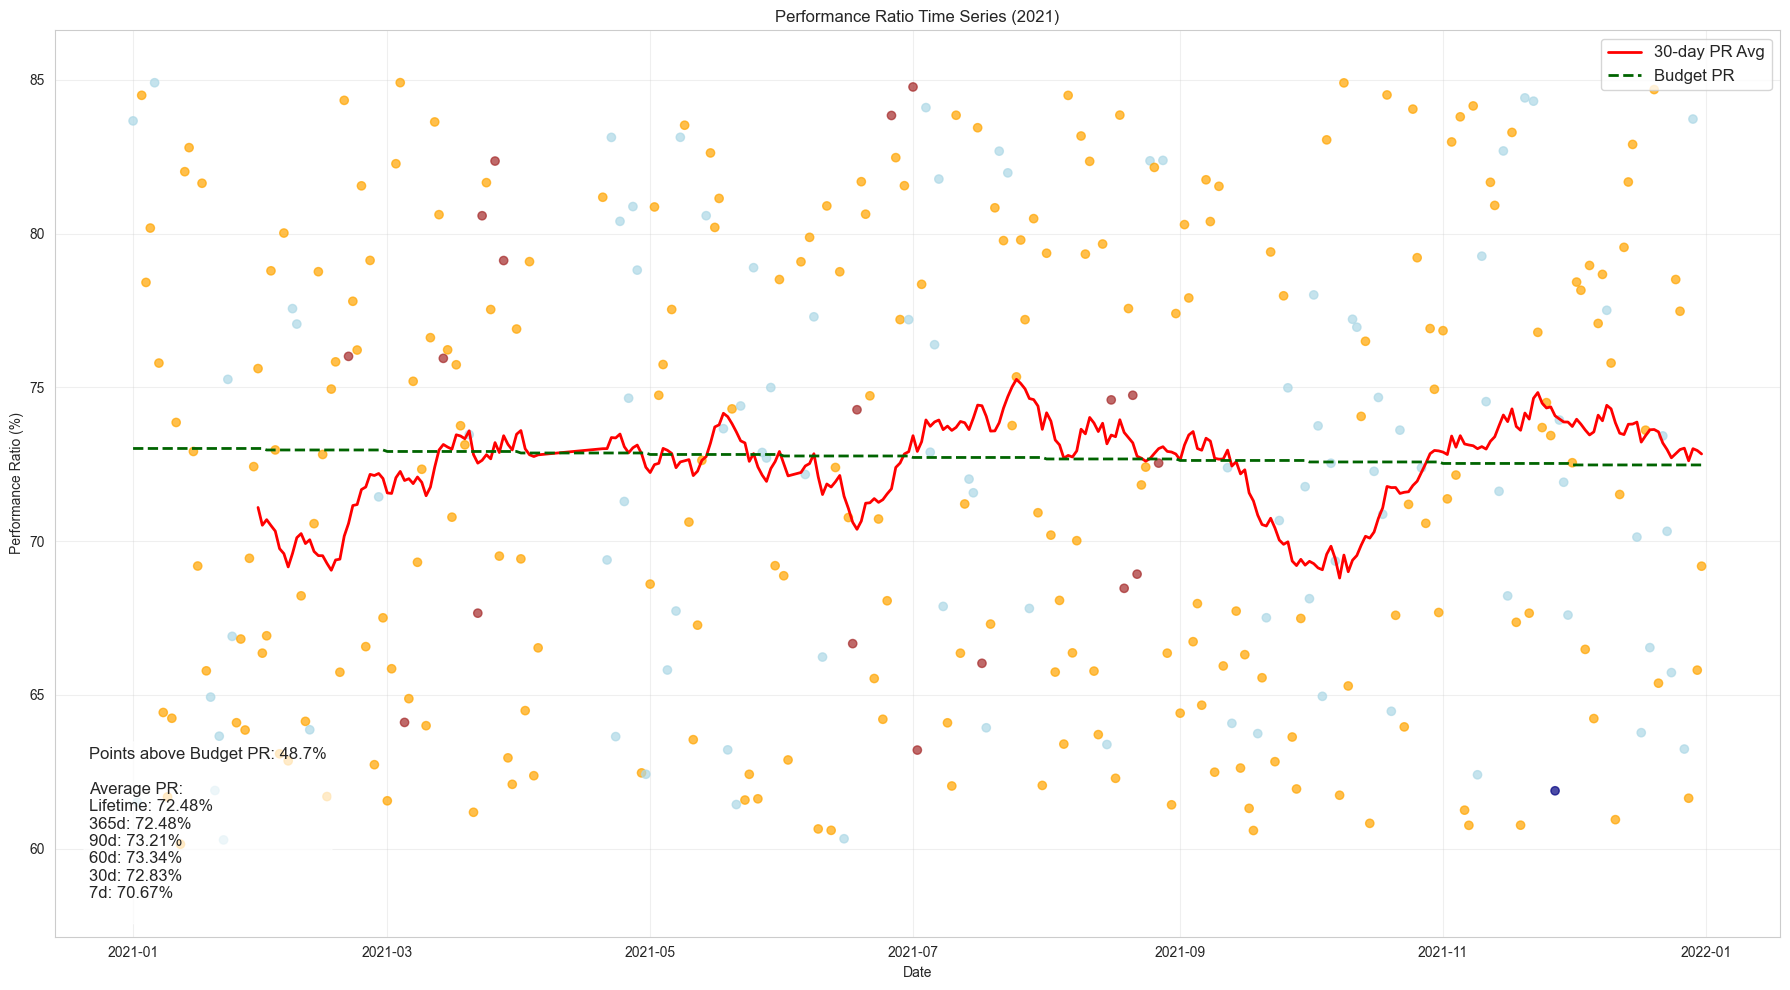


Year-over-year monthly performance:
               PR         GHI      
             mean   std  mean   std
Year Month                         
2019 7      73.61  7.54  4.87  1.23
     8      71.13  7.54  4.61  1.15
     9      73.66  7.17  4.21  1.35
     10     72.66  6.53  5.02  0.81
     11     72.93  6.93  4.52  0.93
     12     73.62  8.02  4.47  0.52
2020 1      72.53  7.00  4.60  0.61
     2      73.04  7.49  5.17  0.75
     3      72.52  6.64  5.27  0.76
     4      73.67  7.37  5.31  0.92
     5      72.57  7.40  4.89  1.04
     6      72.64  6.77  4.66  1.27


In [8]:
def summarize_performance(df):
    """
    Generate performance summary statistics and time series visualizations.
    """
    # --- Ensure correct types ---
    df['Date'] = pd.to_datetime(df['Date'])
    df['GHI'] = pd.to_numeric(df['GHI'], errors='coerce')
    df['PR'] = pd.to_numeric(df['PR'], errors='coerce')

    # --- Summary statistics ---
    print("=== Performance Summary Statistics ===")
    print(f"Data period: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
    print(f"Total days: {df.shape[0]}")
    print(f"Average PR: {df['PR'].mean():.2f}% ± {df['PR'].std():.2f}%")
    print(f"Average GHI: {df['GHI'].mean():.2f} ± {df['GHI'].std():.2f} kWh/m²")
    print(f"PR-GHI correlation: {df['PR'].corr(df['GHI']):.4f}")

    # --- PR time series plots ---
    plot_pr_graph(df, output_path="output/pr_graph_full.png", title="Performance Ratio Time Series (Full Dataset)")
    plot_pr_graph(df, output_path="output/pr_graph_2021.png", start_date="2021-01-01", end_date="2021-12-31", title="Performance Ratio Time Series (2021)")

    # --- Monthly statistics over years ---
    print("\nYear-over-year monthly performance:")
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    yearly_monthly = df.groupby(['Year', 'Month'])[['PR', 'GHI']].agg(['mean', 'std']).round(2)
    print(yearly_monthly.head(12))  # Show first year as example

# Generate performance summary
summarize_performance(df)

## Anomaly Detection

Standard deviation of PR deviations: 7.28%
Using 2.0 standard deviations as anomaly threshold
Detected 0 anomalies (0.0% of data)


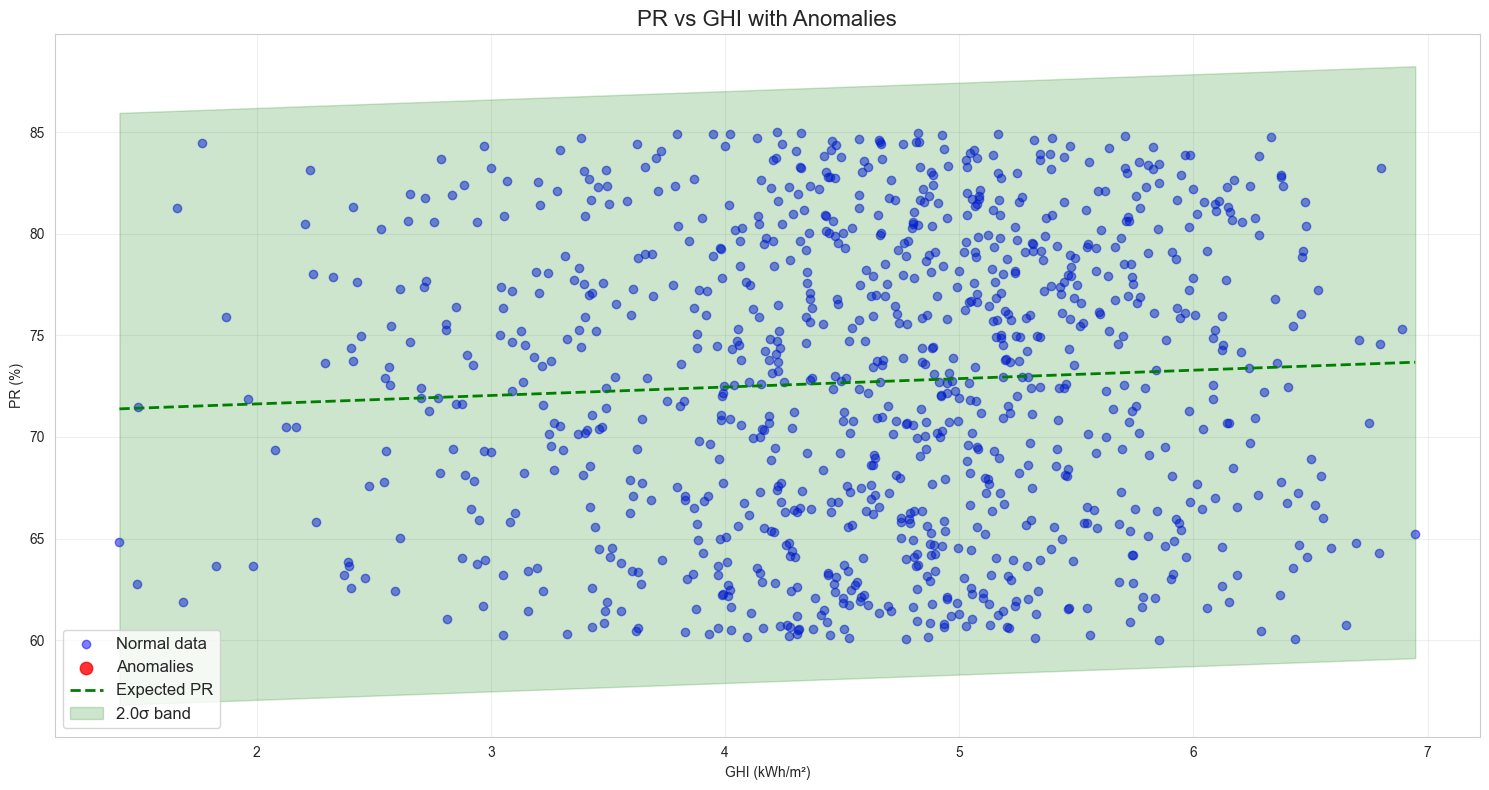


Top 10 anomalies by absolute PR deviation:
    Date  GHI  PR  Expected_PR  PR_Deviation
237  NaT  NaN NaN          NaN           NaN
417  NaT  NaN NaN          NaN           NaN
956  NaT  NaN NaN          NaN           NaN
464  NaT  NaN NaN          NaN           NaN
938  NaT  NaN NaN          NaN           NaN
21   NaT  NaN NaN          NaN           NaN
57   NaT  NaN NaN          NaN           NaN
218  NaT  NaN NaN          NaN           NaN
561  NaT  NaN NaN          NaN           NaN
546  NaT  NaN NaN          NaN           NaN


In [9]:
def detect_anomalies(df, std_dev_threshold=2.0):
    """
    Detect anomalies in PR data based on GHI relationship
    """
    # --- Add date components ---
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['Season'] = pd.cut(
        df['Month'],
        bins=[0, 3, 6, 9, 12],
        labels=['Winter', 'Spring', 'Summer', 'Fall'],
        include_lowest=False,
        right=True
    )
    # --- Linear regression model ---
    X = df['GHI'].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, df['PR'].values)
    df['Expected_PR'] = model.predict(X)
    df['PR_Deviation'] = df['PR'] - df['Expected_PR']
    # --- Anomaly detection ---
    std_dev = df['PR_Deviation'].std()
    print(f"Standard deviation of PR deviations: {std_dev:.2f}%")
    print(f"Using {std_dev_threshold} standard deviations as anomaly threshold")
    df['Anomaly'] = np.abs(df['PR_Deviation']) > std_dev_threshold * std_dev
    # --- Save enhanced dataset ---
    anomaly_count = df['Anomaly'].sum()
    print(f"Detected {anomaly_count} anomalies ({anomaly_count/len(df):.1%} of data)")
    # --- Visualization ---
    plt.figure(figsize=(15, 8))
    plt.scatter(df[~df['Anomaly']]['GHI'], df[~df['Anomaly']]['PR'], alpha=0.5, color='blue', label='Normal data')
    plt.scatter(df[df['Anomaly']]['GHI'], df[df['Anomaly']]['PR'], alpha=0.8, color='red', s=80, label='Anomalies')
    ghi_sorted = np.array(sorted(df['GHI']))
    plt.plot(ghi_sorted, model.predict(ghi_sorted.reshape(-1, 1)), color='green', linestyle='--', linewidth=2, label='Expected PR')
    plt.fill_between(
        ghi_sorted,
        model.predict(ghi_sorted.reshape(-1, 1)) - std_dev_threshold * std_dev,
        model.predict(ghi_sorted.reshape(-1, 1)) + std_dev_threshold * std_dev,
        color='green',
        alpha=0.2,
        label=f'{std_dev_threshold}σ band'
    )
    plt.title('PR vs GHI with Anomalies', fontsize=16)
    plt.xlabel('GHI (kWh/m²)')
    plt.ylabel('PR (%)')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("output/anomaly_detection.png", dpi=300)
    plt.show()
    # --- List top anomalies ---
    top_anomalies = df[df['Anomaly']].reindex(df['PR_Deviation'].abs().sort_values(ascending=False).index).head(10)
    print("\nTop 10 anomalies by absolute PR deviation:")
    print(top_anomalies[['Date', 'GHI', 'PR', 'Expected_PR', 'PR_Deviation']].round(2))
    return df
# Detect anomalies in the data
df_with_anomalies = detect_anomalies(df)

## GHI Monthly Analysis

Monthly GHI averages across all years:
    Month   GHI
0       1  4.47
1       2  4.96
2       3  5.22
3       4  4.87
4       5  4.52
5       6  4.81
6       7  4.78
7       8  4.92
8       9  4.47
9      10  4.22
10     11  4.25
11     12  4.27


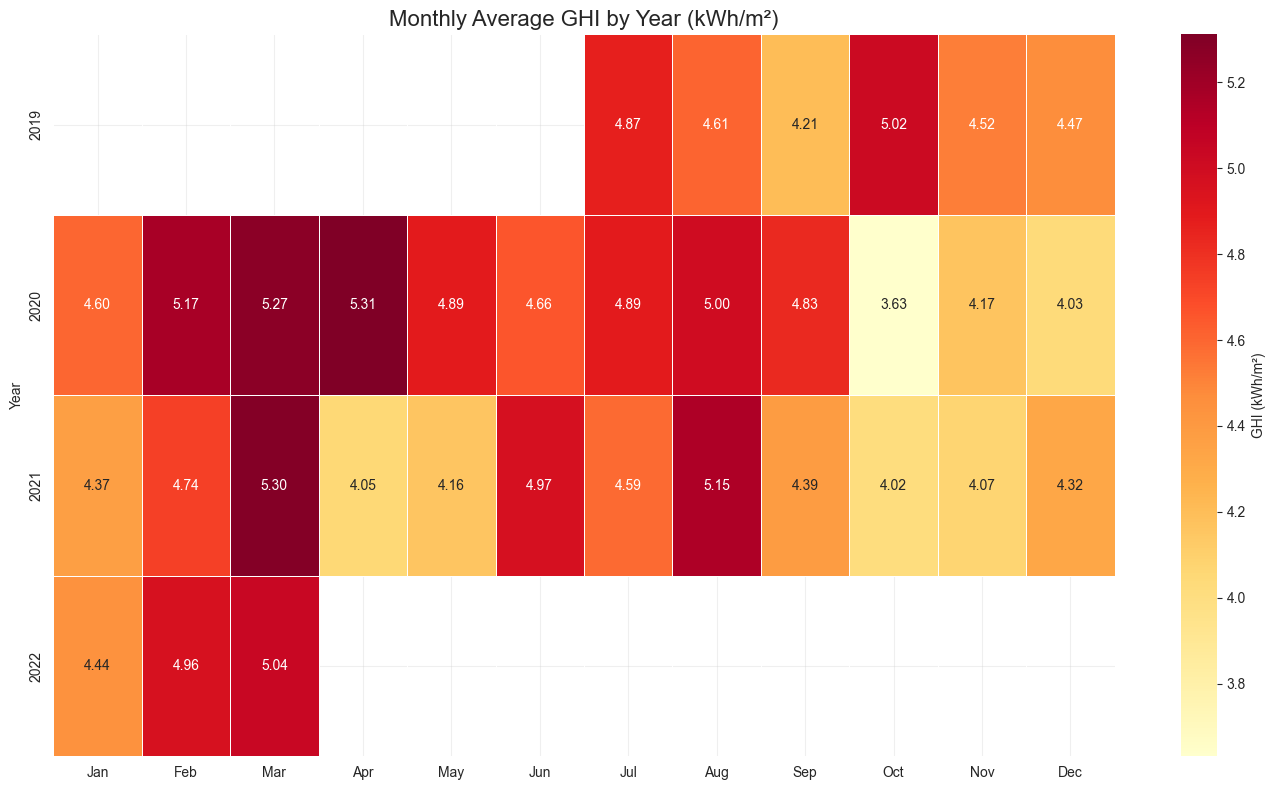

C:\Users\dhruv\AppData\Local\Temp\ipykernel_25720\2037332631.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Date'].dt.strftime('%b'), y=df['GHI'], order=month_names, palette='YlOrRd')


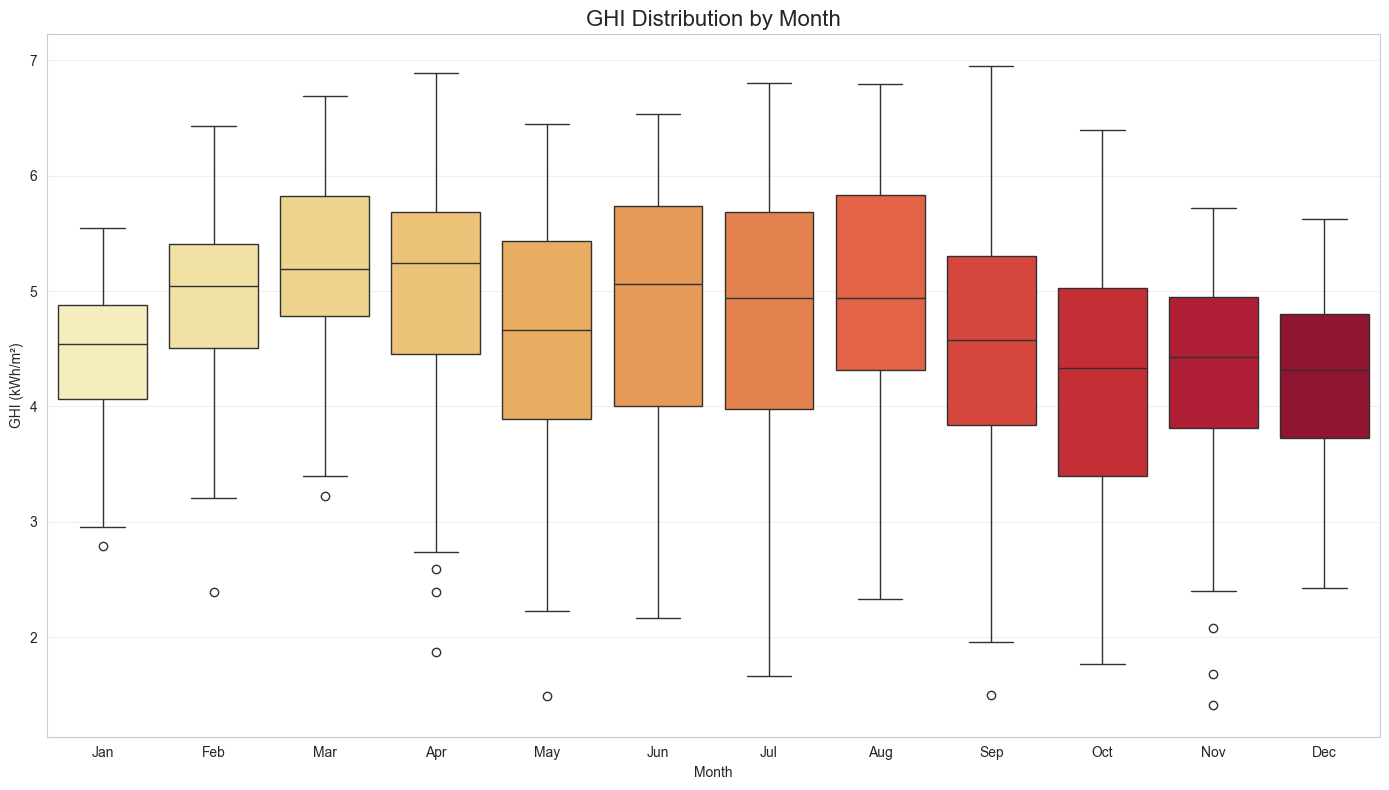

C:\Users\dhruv\AppData\Local\Temp\ipykernel_25720\2037332631.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='GHI', data=yearly_ghi, palette='viridis')


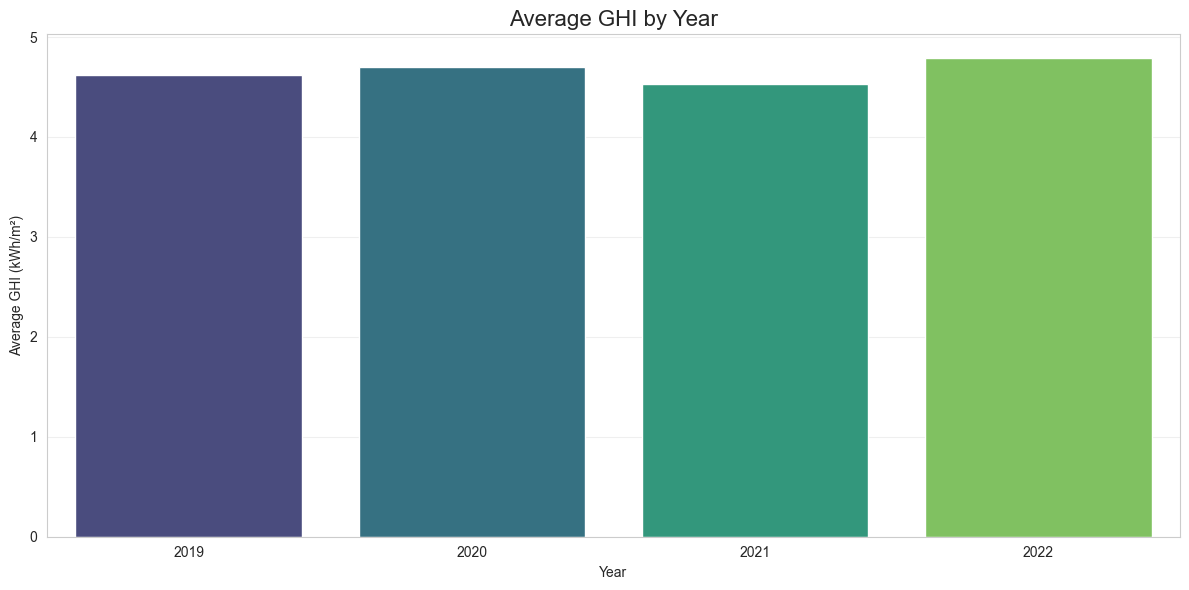

In [10]:
def analyze_monthly_ghi(df):
    """
    Analyze monthly GHI patterns across years
    """
    # --- Prepare data ---
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month

    # --- Monthly average GHI ---
    monthly_ghi = df.groupby('Month')['GHI'].mean().reset_index()
    print("Monthly GHI averages across all years:")
    print(monthly_ghi.round(2))

    # --- Monthly GHI heatmap ---
    monthly_ghi_avg = df.pivot_table(index='Year', columns='Month', values='GHI', aggfunc='mean')
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_ghi_avg.columns = month_names[:len(monthly_ghi_avg.columns)]
    plt.figure(figsize=(14, 8))
    sns.heatmap(monthly_ghi_avg, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5, cbar_kws={'label': 'GHI (kWh/m²)'})
    plt.title("Monthly Average GHI by Year (kWh/m²)", fontsize=16)
    plt.tight_layout()
    plt.savefig("output/ghi_monthly_heatmap.png", dpi=300)
    plt.show()

    # --- Boxplot of monthly GHI distribution ---
    plt.figure(figsize=(14, 8))
    sns.boxplot(x=df['Date'].dt.strftime('%b'), y=df['GHI'], order=month_names, palette='YlOrRd')
    plt.title('GHI Distribution by Month', fontsize=16)
    plt.xlabel('Month')
    plt.ylabel('GHI (kWh/m²)')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig("output/ghi_boxplot_by_month.png", dpi=300)
    plt.show()

    # --- Year-over-year GHI changes ---
    yearly_ghi = df.groupby('Year')['GHI'].mean().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Year', y='GHI', data=yearly_ghi, palette='viridis')
    plt.title('Average GHI by Year', fontsize=16)
    plt.xlabel('Year')
    plt.ylabel('Average GHI (kWh/m²)')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig("output/yearly_ghi.png", dpi=300)
    plt.show()

# Analyze monthly GHI patterns
analyze_monthly_ghi(df)